In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [3]:
names = ["NaN", "user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis"]
data = pd.read_csv("C:/Users/GACHON/Desktop/AiStudy/data/WISDM.csv", header=None, names=names, skiprows=1)

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"] = df["z_axis"].replace(regex=True, to_replace=r';', value=r'')
    # ... and then this column must be transformed to float explicitly
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

(1098203, 6)


In [4]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098203 entries, 0 to 1098202
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x_axis     1098203 non-null  float64
 4   y_axis     1098203 non-null  float64
 5   z_axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 50.3+ MB


In [6]:
df = df[~df['activity'].str.contains('Jogging|Sitting|Upstairs|Downstairs')]

In [7]:
print(df['activity'].value_counts())

activity
Walking     424397
Standing     48395
Name: count, dtype: int64


In [8]:
mapping = {'Walking': 0, 'Standing': 1}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
597,33,Walking,49394992294000,0.844462,8.008764,2.792171,0
598,33,Walking,49395102310000,1.116869,8.621680,3.786457,0
599,33,Walking,49395202316000,-0.503953,16.657684,1.307553,0
600,33,Walking,49395302292000,4.794363,10.760075,-1.184970,0
601,33,Walking,49395412338000,-0.040861,9.234595,-0.694638,0
...,...,...,...,...,...,...,...
1095664,19,Standing,131477821443000,-4.990000,8.390000,-0.380000,1
1095665,19,Standing,131477861513000,-5.130000,8.240000,-0.420000,1
1095666,19,Standing,131477941499000,-4.560000,8.500000,-0.890000,1
1095667,19,Standing,131477981508000,-4.480000,8.540000,-1.080000,1


In [9]:
df.shape

(472792, 7)

C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


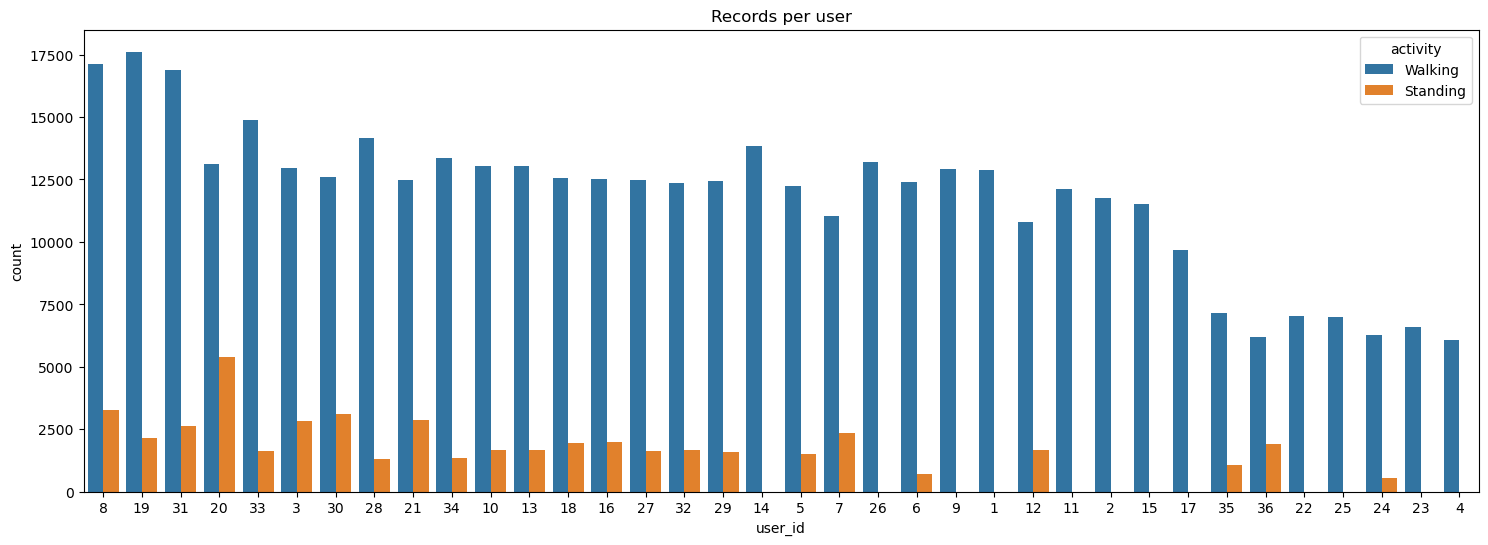

In [10]:
plt.figure(figsize=(18, 6))
sns.countplot(x = "user_id", hue="activity", data = df,
              order = df.user_id.value_counts().index)
plt.title("Records per user");

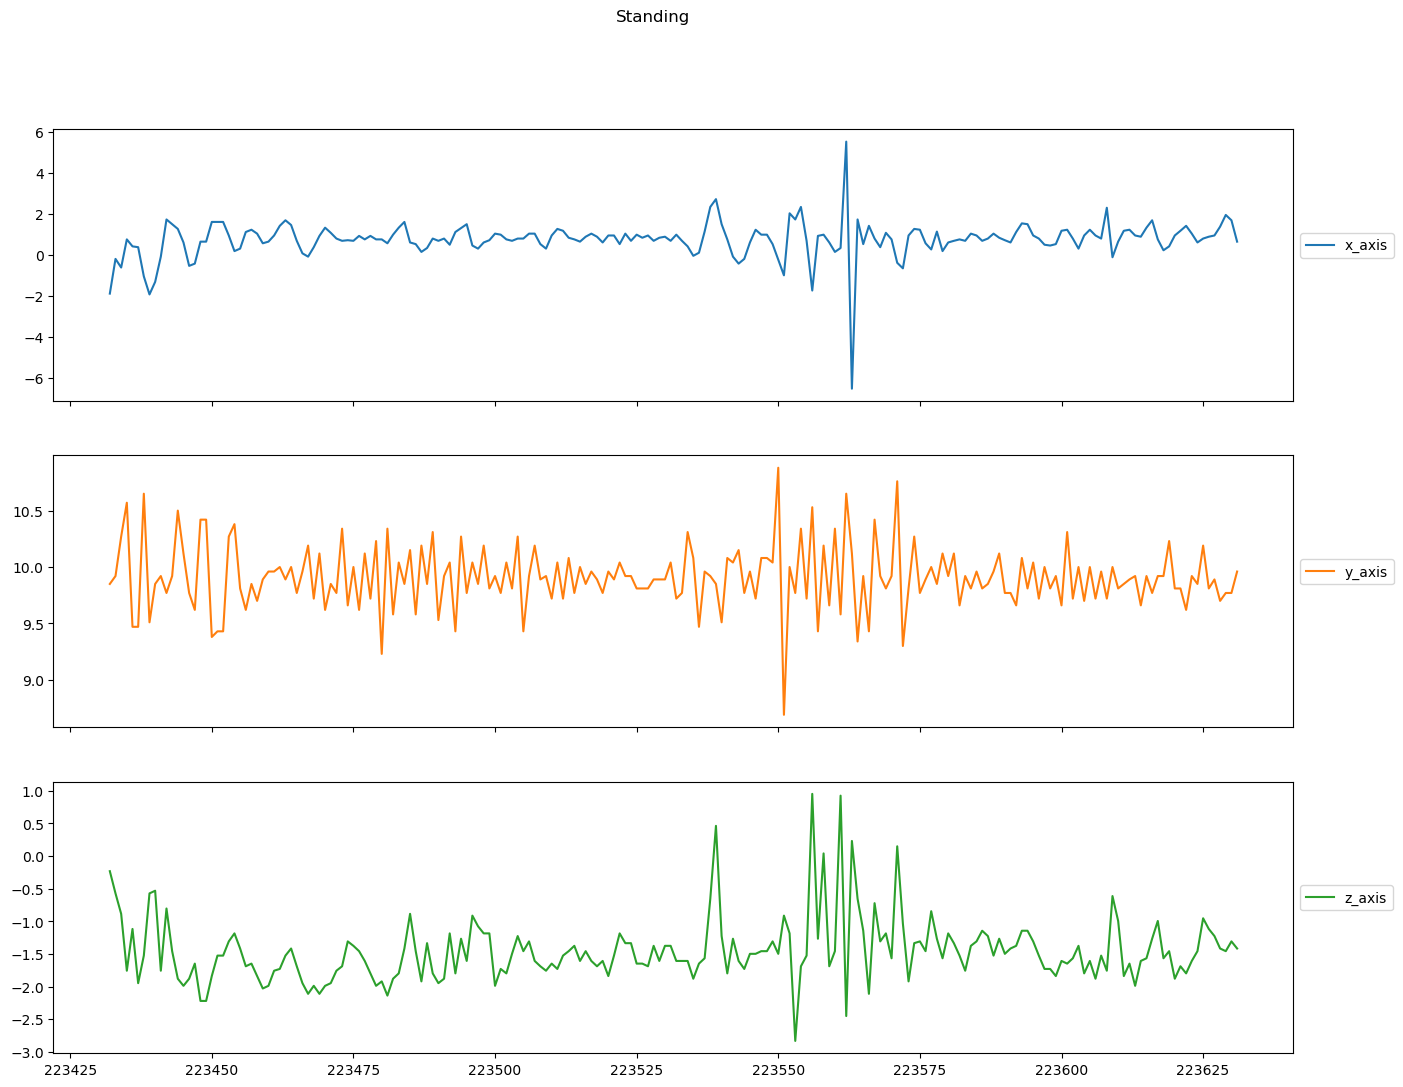

In [11]:
def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Standing", df)

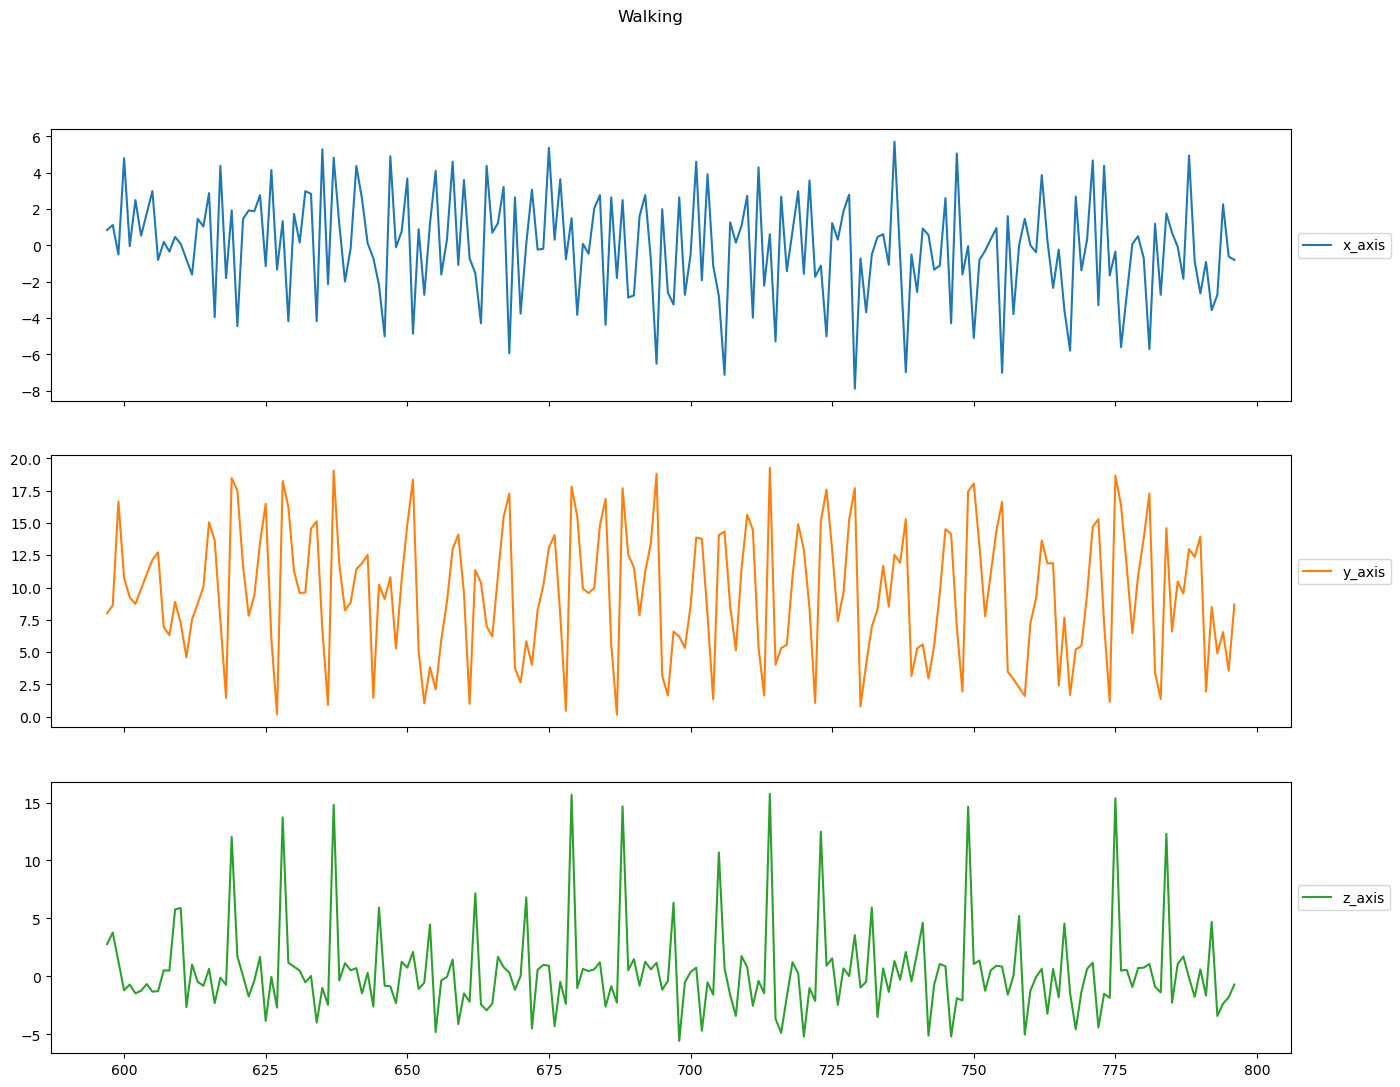

In [12]:
def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Walking", df)

In [13]:
X = df[["x_axis", "y_axis", "z_axis"]].values
y = df['ActivityEncoded'].values.reshape(-1, 1)

In [14]:
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify= y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(302586, 3) (302586, 1)
(94559, 3) (94559, 1)


In [15]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
enc.fit(y_train)

y_train_hot = enc.transform(y_train) 
y_test_hot = enc.transform(y_test) 
y_val_hot = enc.transform(y_val)

In [16]:
n_features, n_outputs = X_train.shape[1], y_train_hot.shape[1]

## 데이터 밸런싱 전 모델 

In [17]:
model = keras.Sequential()
model.add(keras.layers.Dense(50, activation='relu', input_shape=(n_features,)))
model.add(Flatten())
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                200       
                                                                 
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 102       
                                                                 
Total params: 302
Trainable params: 302
Non-trainable params: 0
_________________________________________________________________


In [18]:
epochs, batch_size = 10, 128
history = model.fit(X_train, y_train_hot, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val_hot), shuffle=True)

Epoch 1/10
2364/2364 [==============================] - 7s 2ms/step - loss: 0.2495 - accuracy: 0.8976 - val_loss: 0.2287 - val_accuracy: 0.8977
Epoch 2/10
2364/2364 [==============================] - 6s 3ms/step - loss: 0.1995 - accuracy: 0.9098 - val_loss: 0.1802 - val_accuracy: 0.9270
Epoch 3/10
2364/2364 [==============================] - 7s 3ms/step - loss: 0.1637 - accuracy: 0.9371 - val_loss: 0.1552 - val_accuracy: 0.9426
Epoch 4/10
2364/2364 [==============================] - 7s 3ms/step - loss: 0.1445 - accuracy: 0.9447 - val_loss: 0.1403 - val_accuracy: 0.9461
Epoch 5/10
2364/2364 [==============================] - 7s 3ms/step - loss: 0.1311 - accuracy: 0.9478 - val_loss: 0.1288 - val_accuracy: 0.9495
Epoch 6/10
2364/2364 [==============================] - 7s 3ms/step - loss: 0.1221 - accuracy: 0.9503 - val_loss: 0.1218 - val_accuracy: 0.9490
Epoch 7/10
2364/2364 [==============================] - 6s 3ms/step - loss: 0.1157 - accuracy: 0.9518 - val_loss: 0.1171 - val_accuracy:

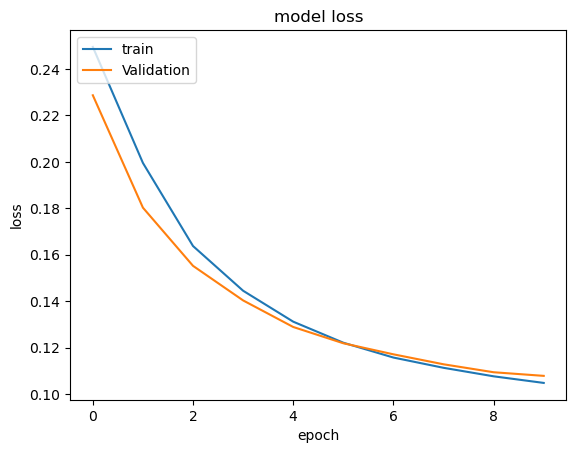

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

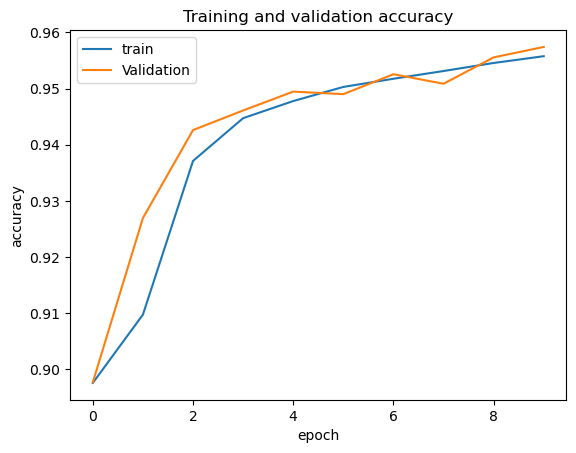

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

2955/2955 [==============================] - 2s 609us/step
f1_score =  0.9569835501294762
0.9575820387271439
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     84880
           1       0.81      0.76      0.79      9679

    accuracy                           0.96     94559
   macro avg       0.89      0.87      0.88     94559
weighted avg       0.96      0.96      0.96     94559



<Axes: >

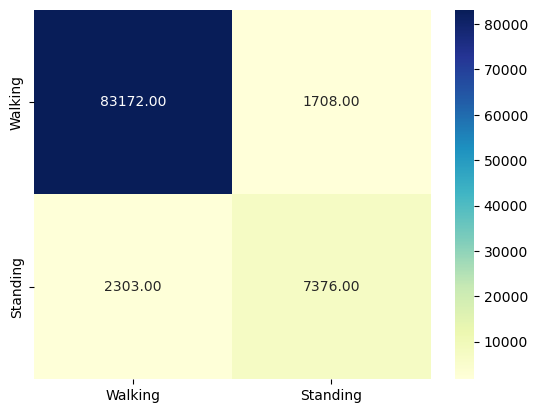

In [21]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking','Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

## Smote()를 통해 각 User 별로 activity의 개수 동일하게 밸런싱

In [22]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# 데이터프레임 그룹화
grouped = df.groupby('user_id')

# 각 그룹에 대해 밸런싱 적용
balanced_dfs = []
for group_name, group_data in grouped:
    # 그룹 내 클래스 개수 확인
    num_classes = group_data['activity'].nunique()
    
    # 클래스가 하나 이상인 경우에만 밸런싱 적용, Standing이 존재하지 않는 user가 있어서
    if num_classes > 1:
        # Smote를 통한 Oversampling
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_resampled, y_resampled = smote.fit_resample(group_data.drop(['activity', 'user_id'], axis=1), group_data['activity'])
        balanced_group_df = pd.concat([pd.DataFrame(X_resampled, columns=group_data.drop(['activity', 'user_id'], axis=1).columns),
                                       pd.DataFrame({'activity': y_resampled})], axis=1)

        # 'user_id' 열 추가
        balanced_group_df['user_id'] = group_name

        balanced_dfs.append(balanced_group_df)
    else:
        balanced_dfs.append(group_data)

# 재결합
balanced_df = pd.concat(balanced_dfs)

# 결과 확인
print(balanced_df.head())

        user_id activity      timestamp  x_axis  y_axis  z_axis  \
941959        1  Walking  4991922345000    0.69   10.80   -2.03   
941960        1  Walking  4991972333000    6.85    7.44   -0.50   
941961        1  Walking  4992022351000    0.93    5.63   -0.50   
941962        1  Walking  4992072339000   -2.11    5.01   -0.69   
941963        1  Walking  4992122358000   -4.59    4.29   -1.95   

        ActivityEncoded  
941959                0  
941960                0  
941961                0  
941962                0  
941963                0  


C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


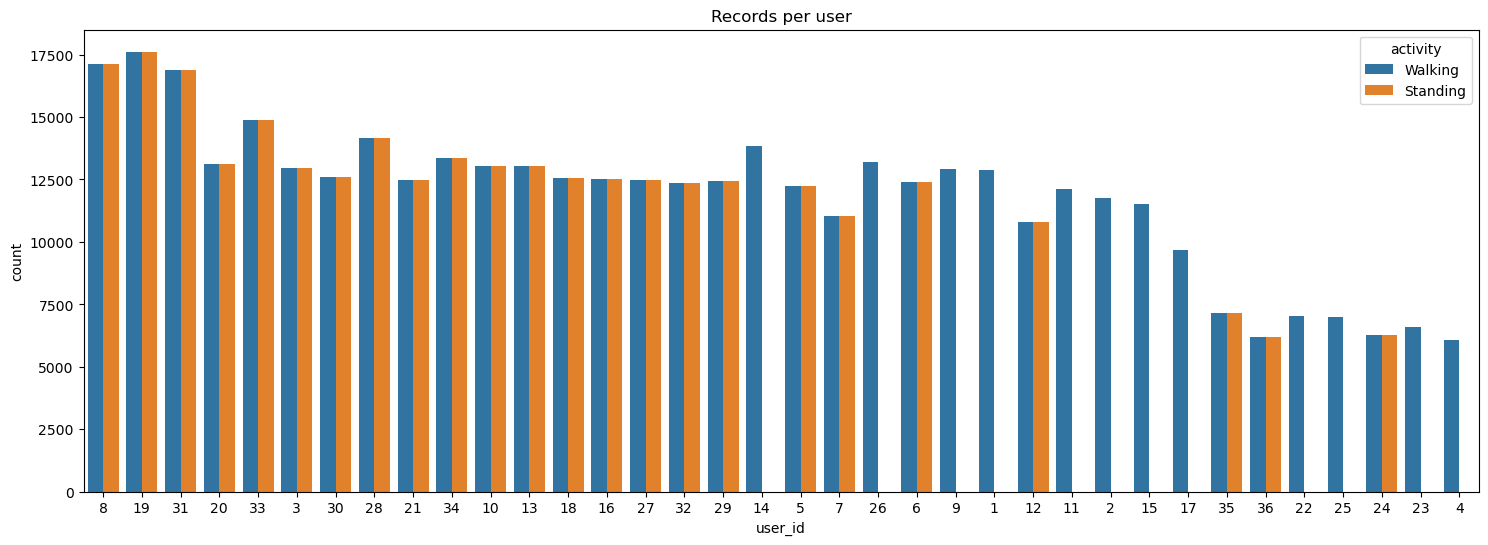

In [23]:
plt.figure(figsize=(18, 6))
sns.countplot(x = "user_id", hue="activity", data = balanced_df,
              order = df.user_id.value_counts().index)
plt.title("Records per user");

In [24]:
X = balanced_df[["x_axis", "y_axis", "z_axis"]].values
y = balanced_df['ActivityEncoded'].values.reshape(-1, 1)

In [25]:
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify= y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(463476, 3) (463476, 1)
(144837, 3) (144837, 1)


In [26]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
enc.fit(y_train)

y_train_hot = enc.transform(y_train) 
y_test_hot = enc.transform(y_test) 
y_val_hot = enc.transform(y_val)

In [27]:
n_features, n_outputs = X_train.shape[1], y_train_hot.shape[1]

In [28]:
model = keras.Sequential()
model.add(keras.layers.Dense(50, activation='relu', input_shape=(n_features,)))
model.add(Flatten())
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 50)                200       
                                                                 
 flatten_1 (Flatten)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 102       
                                                                 
Total params: 302
Trainable params: 302
Non-trainable params: 0
_________________________________________________________________


In [29]:
epochs, batch_size = 10, 128
history = model.fit(X_train, y_train_hot, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val_hot), shuffle=True)

Epoch 1/10
3621/3621 [==============================] - 11s 3ms/step - loss: 0.3990 - accuracy: 0.8142 - val_loss: 0.2817 - val_accuracy: 0.8915
Epoch 2/10
3621/3621 [==============================] - 10s 3ms/step - loss: 0.2415 - accuracy: 0.9066 - val_loss: 0.2101 - val_accuracy: 0.9220
Epoch 3/10
3621/3621 [==============================] - 10s 3ms/step - loss: 0.1923 - accuracy: 0.9300 - val_loss: 0.1766 - val_accuracy: 0.9380
Epoch 4/10
3621/3621 [==============================] - 10s 3ms/step - loss: 0.1694 - accuracy: 0.9388 - val_loss: 0.1614 - val_accuracy: 0.9440
Epoch 5/10
3621/3621 [==============================] - 10s 3ms/step - loss: 0.1565 - accuracy: 0.9436 - val_loss: 0.1532 - val_accuracy: 0.9465
Epoch 6/10
3621/3621 [==============================] - 10s 3ms/step - loss: 0.1478 - accuracy: 0.9475 - val_loss: 0.1493 - val_accuracy: 0.9523
Epoch 7/10
3621/3621 [==============================] - 10s 3ms/step - loss: 0.1433 - accuracy: 0.9497 - val_loss: 0.1411 - val_ac

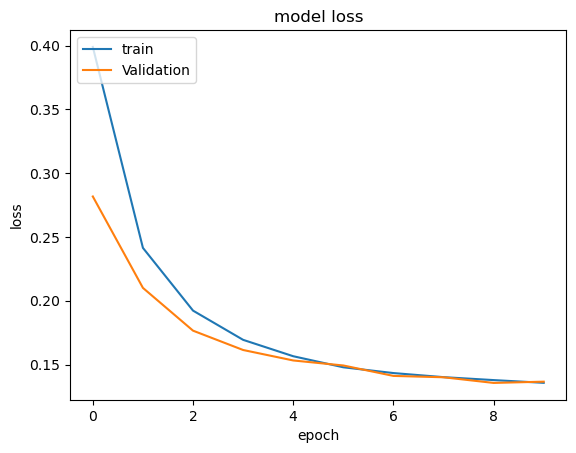

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

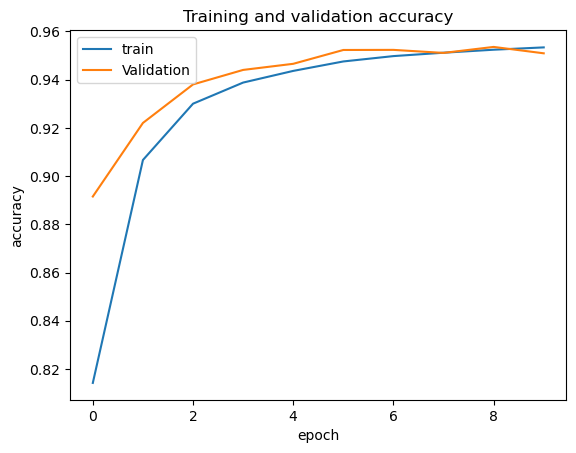

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

4527/4527 [==============================] - 3s 645us/step
f1_score =  0.9505933873426202
0.9503579886355006
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     84880
           1       0.91      0.98      0.94     59957

    accuracy                           0.95    144837
   macro avg       0.95      0.95      0.95    144837
weighted avg       0.95      0.95      0.95    144837



<Axes: >

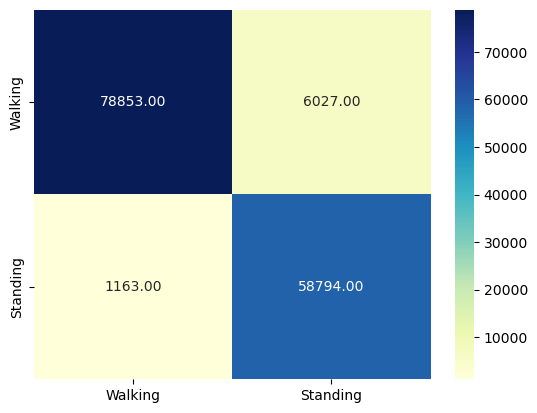

In [32]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking','Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

## Standing 활동이 없는 user에 의해 전체 activity의 밸런스가 맞지 않는 것을 해결하기 위해 Standing 활동이 없는 user의 행 삭제

In [33]:
# 'Standing' 활동을 하는 user_id 추출
standing_users = balanced_df[balanced_df['activity'] == 'Standing']['user_id'].unique()

# 'Standing' 활동을 하지 않는 user_id 추출
standing_absent_users = [user_id for user_id in df['user_id'].unique() if user_id not in standing_users]

# 'Standing' 활동을 하지 않는 user_id에 해당하는 행 삭제
balanced_df = balanced_df[~balanced_df['user_id'].isin(standing_absent_users)]

# 결과 확인
print(balanced_df)

       user_id  activity        timestamp    x_axis     y_axis    z_axis  \
0            3   Walking  100832351478000  2.870000  18.810000 -0.890000   
1            3   Walking  100832391547000 -0.380000   8.240000 -1.270000   
2            3   Walking  100832431556000  1.330000   7.160000 -1.950000   
3            3   Walking  100832471839000  4.060000   9.660000 -1.840000   
4            3   Walking  100832551551000  1.690000   6.550000 -0.110000   
...        ...       ...              ...       ...        ...       ...   
12395       36  Standing   15044089412035 -1.554364   9.421052  2.425855   
12396       36  Standing   14986551250491 -0.707508   9.430000  2.716778   
12397       36  Standing   14961678839999 -0.566816   9.343184  2.683209   
12398       36  Standing   15020569293143 -1.652384   9.387748  2.065422   
12399       36  Standing   14957988284301 -0.190000   9.596540  2.481873   

       ActivityEncoded  
0                    0  
1                    0  
2           

C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


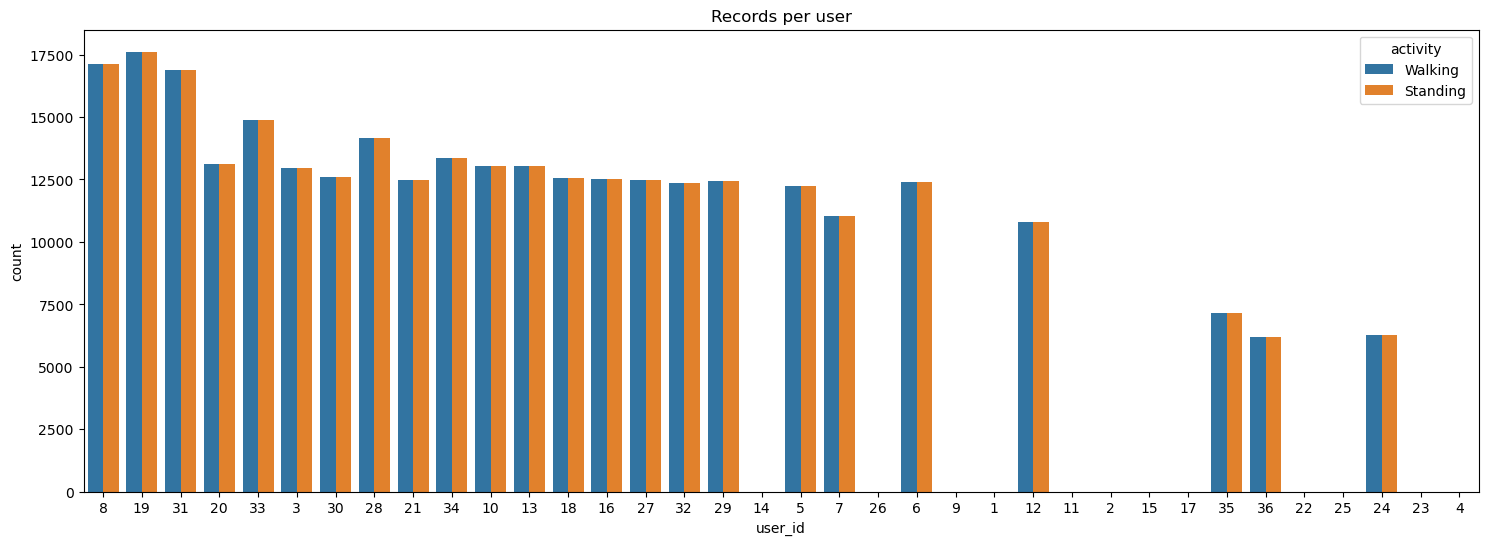

In [34]:
plt.figure(figsize=(18, 6))
sns.countplot(x = "user_id", hue="activity", data = balanced_df,
              order = df.user_id.value_counts().index)
plt.title("Records per user");

In [35]:
X = balanced_df[["x_axis", "y_axis", "z_axis"]].values
y = balanced_df['ActivityEncoded'].values.reshape(-1, 1)

In [36]:
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify= y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(383724, 3) (383724, 1)
(119914, 3) (119914, 1)


In [37]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
enc.fit(y_train)

y_train_hot = enc.transform(y_train) 
y_test_hot = enc.transform(y_test) 
y_val_hot = enc.transform(y_val)

In [38]:
n_features, n_outputs = X_train.shape[1], y_train_hot.shape[1]

In [39]:
model = keras.Sequential()
model.add(keras.layers.Dense(50, activation='relu', input_shape=(n_features,)))
model.add(Flatten())
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 50)                200       
                                                                 
 flatten_2 (Flatten)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 102       
                                                                 
Total params: 302
Trainable params: 302
Non-trainable params: 0
_________________________________________________________________


In [40]:
epochs, batch_size = 10, 128
history = model.fit(X_train, y_train_hot, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val_hot), shuffle=True)

Epoch 1/10
2998/2998 [==============================] - 9s 3ms/step - loss: 0.4180 - accuracy: 0.8109 - val_loss: 0.2927 - val_accuracy: 0.8883
Epoch 2/10
2998/2998 [==============================] - 8s 3ms/step - loss: 0.2464 - accuracy: 0.9082 - val_loss: 0.2122 - val_accuracy: 0.9225
Epoch 3/10
2998/2998 [==============================] - 8s 3ms/step - loss: 0.1960 - accuracy: 0.9311 - val_loss: 0.1787 - val_accuracy: 0.9339
Epoch 4/10
2998/2998 [==============================] - 8s 3ms/step - loss: 0.1702 - accuracy: 0.9415 - val_loss: 0.1585 - val_accuracy: 0.9453
Epoch 5/10
2998/2998 [==============================] - 8s 3ms/step - loss: 0.1561 - accuracy: 0.9473 - val_loss: 0.1519 - val_accuracy: 0.9526
Epoch 6/10
2998/2998 [==============================] - 8s 3ms/step - loss: 0.1484 - accuracy: 0.9504 - val_loss: 0.1442 - val_accuracy: 0.9504
Epoch 7/10
2998/2998 [==============================] - 8s 3ms/step - loss: 0.1438 - accuracy: 0.9523 - val_loss: 0.1431 - val_accuracy:

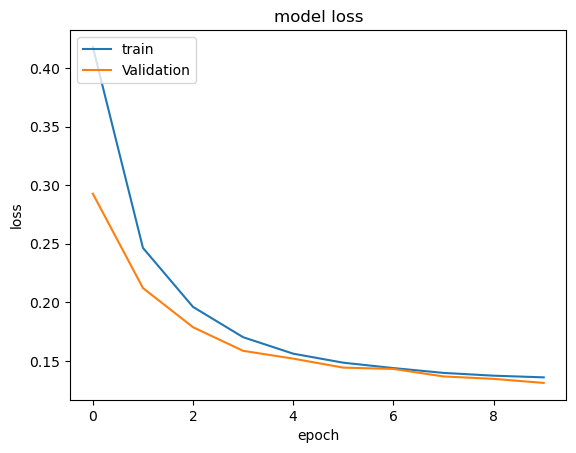

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

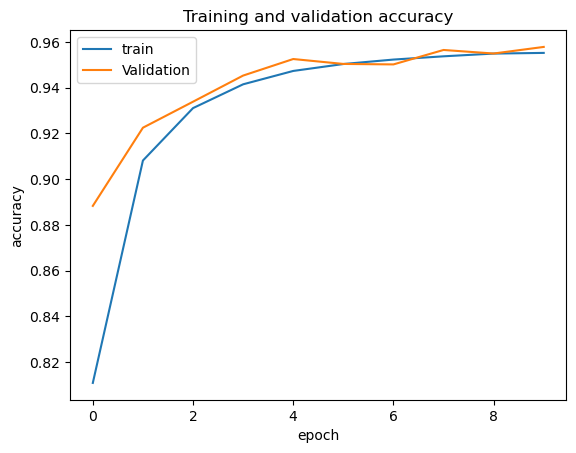

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

3748/3748 [==============================] - 3s 678us/step
f1_score =  0.957277909029906
0.9573110729356038
              precision    recall  f1-score   support

           0       0.98      0.93      0.96     59957
           1       0.93      0.99      0.96     59957

    accuracy                           0.96    119914
   macro avg       0.96      0.96      0.96    119914
weighted avg       0.96      0.96      0.96    119914



<Axes: >

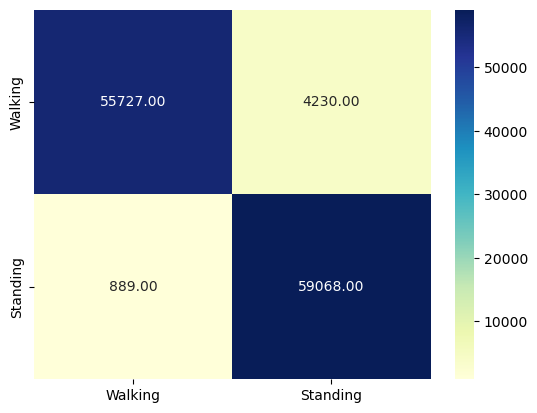

In [43]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking','Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')